# Factors in a business success according to Yelp
### Group: Connor Fitzmaurice 12376761, Kevin Fitzpatrick 15204690, Stephen Murphy 15200153

# Text Prepartion
As part of the data preparation stage of this project, the text features of both the tips and abt datasets will be prepared.
Sentiment will be calculated individually for tips and reviews with numerical values representing sentiment. The factors mentioned in a tip/review will be also calculated with a scale from 0 upwards denoting the weight given towards a factor. These factors were the following, Location, Service, Price, Food, Beverages and were chosen based off some intial textual analysis done using the nltk python libray. This analysis can be seen in the textual analysis notebook. 

For each business, this analysis was then averaged to calculate the main focus of the business based off the reviews/tips recieved and the percenatage of positive/negative reviews/tips.

To enable nltk analysis, the text for tips adnd reviews in the abt will be saved to two text files using numpy.

Any files, plots or other outputs from this notebook will be saved in the Text Preparation folder.

## Data Quality Report
Some issues currently exist with working with the text of the reviews and tips in their datasets due to the structure of the panda column and it current format:
1. No way to do overall text analysis
2. Strings in cells need to be tokenise individually and analysed

Solutions:
1. Use numpy to group text and nltk for analysis
2. Iterate through panda cells using for loop

### Import neccessary Libraries

In [2]:
#Import libraries/packages needed for analysis the reviews and tip text
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import sklearn.feature_extraction.text
import yaml
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.util import *
%matplotlib inline

C:\Users\ray\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
 #Set panda options so whole lines for tips can be view
pd.set_option('max_colwidth', 500)

## Functions required to do text analysis cell by cell
Several classes and functions will be used to do sentiment and factor analysis.

In [4]:
#Source is  http://fjavieralba.com/basic-sentiment-analysis-with-python.html

#Functions and classes with which to do sentiment analysis

#Class to split tips text and tokenize it
class Splitter(object):
    def __init__(self):
        self.nltk_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
        self.nltk_tokenizer = nltk.tokenize.TreebankWordTokenizer()

    def split(self, text):
        """
        input format: a paragraph of text
        output format: a list of lists of words.
            e.g.: [['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'one']]
        """
        sentences = self.nltk_splitter.tokenize(text)
        tokenized_sentences = [self.nltk_tokenizer.tokenize(sent) for sent in sentences]
        return tokenized_sentences

#Class to apply pos( part-of-speech tagging ) tags to tokens
class POSTagger(object):
    def __init__(self):
        pass
        
    def pos_tag(self, sentences):
        """
        input format: list of lists of words
            e.g.: [['this', 'is', 'a', 'sentence'], ['this', 'is', 'another', 'one']]
        output format: list of lists of tagged tokens. Each tagged tokens has a
        form, a lemma, and a list of tags
            e.g: [[('this', 'this', ['DT']), ('is', 'be', ['VB']), ('a', 'a', ['DT']), ('sentence', 'sentence', ['NN'])],
                    [('this', 'this', ['DT']), ('is', 'be', ['VB']), ('another', 'another', ['DT']), ('one', 'one', ['CARD'])]]
        """

        pos = [nltk.pos_tag(sentence) for sentence in sentences]
        #adapt format
        pos = [[(word, word, [postag]) for (word, postag) in sentence] for sentence in pos]
        return pos


In [5]:
#Supports tagging of sentences
class DictionaryTagger(object):
    def __init__(self, dictionary_paths):
        files = [open(path, 'r') for path in dictionary_paths]
        dictionaries = [yaml.load(dict_file) for dict_file in files]
        map(lambda x: x.close(), files)
        self.dictionary = {}
        self.max_key_size = 0
        for curr_dict in dictionaries:
            for key in curr_dict:
                if key in self.dictionary:
                    self.dictionary[key].extend(curr_dict[key])
                else:
                    self.dictionary[key] = curr_dict[key]
                    self.max_key_size = max(self.max_key_size, len(key))

    def tag(self, postagged_sentences):
        return [self.tag_sentence(sentence) for sentence in postagged_sentences]

    def tag_sentence(self, sentence, tag_with_lemmas=False):
        tag_sentence = []
        N = len(sentence)
        if self.max_key_size == 0:
            self.max_key_size = N
        i = 0
        while (i < N):
            j = min(i + self.max_key_size, N) #avoid overflow
            tagged = False
            while (j > i):
                expression_form = ' '.join([word[0] for word in sentence[i:j]]).lower()
                expression_lemma = ' '.join([word[1] for word in sentence[i:j]]).lower()
                if tag_with_lemmas:
                    literal = expression_lemma
                else:
                    literal = expression_form
                if literal in self.dictionary:
                    #self.logger.debug("found: %s" % literal)
                    is_single_token = j - i == 1
                    original_position = i
                    i = j
                    taggings = [tag for tag in self.dictionary[literal]]
                    tagged_expression = (expression_form, expression_lemma, taggings)
                    if is_single_token: #if the tagged literal is a single token, conserve its previous taggings:
                        original_token_tagging = sentence[original_position][2]
                        tagged_expression[2].extend(original_token_tagging)
                    tag_sentence.append(tagged_expression)
                    tagged = True
                else:
                    j = j - 1
            if not tagged:
                tag_sentence.append(sentence[i])
                i += 1
        return tag_sentence

### Analysis for factors such as location, food and price in a business success using various word list in yml files

#### Sentiment Analysis

In [6]:
def value_of(sentiment):
    if sentiment == 'positive': return 1
    if sentiment == 'negative': return -1
    return 0

def sentiment_score(review):    
    return sum ([value_of(tag) for sentence in review for token in sentence for tag in token[2]])

The function for sentiment analysis was adapted to being used to analyse for other factors.

#### Food

In [7]:
def value_of_food(food_mention):
    if food_mention == 'food': return 1
    return 0

def food_score(review):    
    return sum ([value_of_food(tag) for sentence in review for token in sentence for tag in token[2]])

#### Location

In [8]:
def value_of_location(place_mention):
    if place_mention == 'place': return 1
    return 0

def location_score(review):    
    return sum ([value_of_location(tag) for sentence in review for token in sentence for tag in token[2]])

#### Service

In [9]:
def value_of_service(service_mention):
    if service_mention == 'service': return 1
    return 0

def service_score(review):    
    return sum ([value_of_service(tag) for sentence in review for token in sentence for tag in token[2]])

#### Beverages

In [10]:
def value_of_drink(drink_mention):
    if drink_mention == 'drink': return 1
    return 0

def drink_score(review):    
    return sum ([value_of_drink(tag) for sentence in review for token in sentence for tag in token[2]])

#### Price

In [11]:
def value_of_price(price_mention):
    if price_mention == 'price': return 1
    return 0

def price_score(review):    
    return sum ([value_of_price(tag) for sentence in review for token in sentence for tag in token[2]])

### YML containing list for textual analysis

6 YML files are used for textual analysis. These are positive.yml, negative.yml, food.yml, service.yml, price.yml, location.yml and beverages.yml. Each of these files contain an associative array which are used to store an index of words as keys with values associated to them.  

In [12]:
#Load dictionaries from Yml files
#dicttagger_sentiment = DictionaryTagger(['C:/Users/ray/Documents/ConnorStuff/DataAnalytics/positive.yml','C:/Users/ray/Documents/ConnorStuff/DataAnalytics/negative.yml']) 
dicttagger_sentiment = DictionaryTagger(['positive.yml','negative.yml'])

In [13]:
#dicttagger_food = DictionaryTagger(['C:/Users/Connor Fitzmaurice/Documents/COMP47350/DataAnalyticsProject/DataAnalytics/food.yml'])
dicttagger_food = DictionaryTagger(['food.yml'])

In [14]:
#dicttagger_service = DictionaryTagger(['C:/Users/Connor Fitzmaurice/Documents/COMP47350/DataAnalyticsProject/DataAnalytics/service.yml'])
dicttagger_service = DictionaryTagger(['service.yml'])

In [15]:
#dicttagger_price = DictionaryTagger(['C:/Users/Connor Fitzmaurice/Documents/COMP47350/DataAnalyticsProject/price.yml'])
dicttagger_price = DictionaryTagger(['price.yml'])

In [16]:
#dicttagger_location = DictionaryTagger(['C:/Users/Connor Fitzmaurice/Documents/COMP47350/DataAnalyticsProject/location.yml'])
dicttagger_location = DictionaryTagger(['location.yml'])

In [17]:
#dicttagger_beverages = DictionaryTagger(['C:/Users/Connor Fitzmaurice/Documents/COMP47350/DataAnalyticsProject/beverages.yml'])
dicttagger_beverages = DictionaryTagger(['beverages.yml'])

In [18]:
#Read tips csv into dataframe 
tipsDF = pd.read_csv('yelp_tips.csv', index_col=False, encoding='UTF-8')
#tipsDF = pd.read_csv('C:/Users/ray/Documents/ConnorStuff/DataAnalytics/CSV_Files/yelp_tips.csv', index_col=False, encoding='UTF-8')

## Basic text exploration

In [18]:
# Initial Table Head
tipsDF.head()

,Unnamed: 0,business_id,date,likes,text,type,user_id
0,0,cE27W9VPgO88Qxe4ol6y_g,2013-04-18,0,Don't waste your time.,tip,-6rEfobYjMxpUWLNxszaxQ
1,1,mVHrayjG3uZ_RLHkLj-AMg,2013-01-06,1,Your GPS will not allow you to find this place. Put Rankin police department in instead. They are directly across the street.,tip,EZ0r9dKKtEGVx2CdnowPCw
2,2,KayYbHCt-RkbGcPdGOThNg,2013-12-03,0,Great drink specials!,tip,xb6zEQCw9I-Gl0g06e1KsQ
3,3,KayYbHCt-RkbGcPdGOThNg,2015-07-08,0,"Friendly staff, good food, great beer selection, and relaxing atmosphere",tip,QawZN4PSW7ng_9SP7pjsVQ
4,4,1_lU0-eSWJCRvNGk78Zh9Q,2015-10-25,0,Beautiful restoration.,tip,MLQre1nvUtW-RqMTc4iC9A


In [19]:
#Initial table tail
tipsDF.tail()

,Unnamed: 0,business_id,date,likes,text,type,user_id
591859,591859,NQQ9N-PLf3D-pguttlZ0JA,2015-12-26,0,We need more of this in VEGAs!!!!!!!!!!!,tip,o2q16gP1thKHyvhOOJsZZQ
591860,591860,NQQ9N-PLf3D-pguttlZ0JA,2015-12-21,0,It's open late on Friday and Saturdays until midnight.,tip,o2q16gP1thKHyvhOOJsZZQ
591861,591861,g51EInNrq2qhD3wkK2Dv7g,2015-12-21,0,"Have fun, wish I was there but instead I'll have to make do with sitting in Atlanta Airport waiting to go on to Vegas!",tip,SM4FFgXlhHzuDJNRI6HDCA
591862,591862,11BQ6VK8UsaFa4KJPup6Hg,2015-01-16,0,"Barista Artell was super friendly, personable and made my Strawberry-Banana-Whey smoothie deliciously.",tip,95pMy0M4Ta7ubjEcQP6f8w
591863,591863,11BQ6VK8UsaFa4KJPup6Hg,2015-08-17,0,Road fuel,tip,jGFQJXxJ2KiomYWFFcr5lQ


In [20]:
#Drop unnamed index column as Panda adds its own one. Run this once only
tipsDF = tipsDF.drop(tipsDF.columns[0], axis = 1)

In [21]:
#Check dataset features
tipsDF.dtypes

business_id    object
date           object
likes           int64
text           object
type           object
user_id        object
dtype: object

In [22]:
#Number of rows and features
tipsDF.shape

(591864, 6)

### Exploration to see if tips could be used as a target feature
Some basic text exploration surrounding the tip feature to determine how useful the like feature is as a target feature for the tips

In [23]:
# Check the overall amount of likes
print(tipsDF.groupby('likes').count())

       business_id    date    text    type  user_id
likes                                              
0           583709  583709  583709  583709   583709
1             7495    7495    7495    7495     7495
2              543     543     543     543      543
3               80      80      80      80       80
4               21      21      21      21       21
5                9       9       9       9        9
6                3       3       3       3        3
7                1       1       1       1        1
8                1       1       1       1        1
9                1       1       1       1        1
10               1       1       1       1        1


In [24]:
# Descriptive Statistics
print(tipsDF.describe())

               likes
count  591864.000000
mean        0.015210
std         0.137642
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C010210FD0>]], dtype=object)

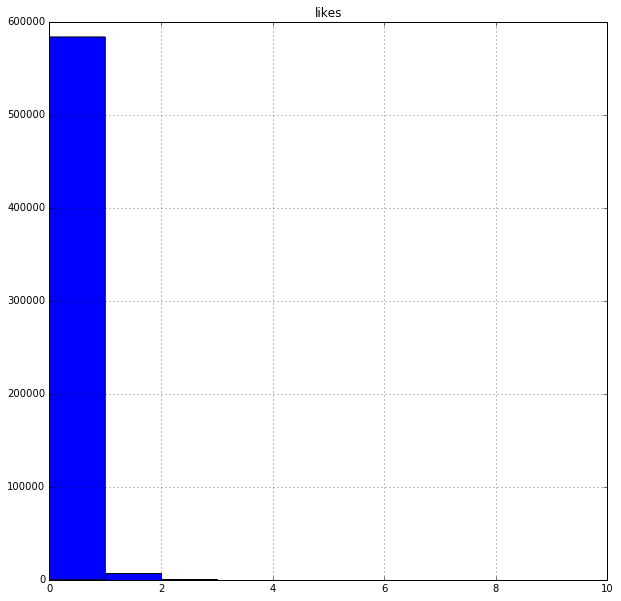

In [25]:
tipsDF.hist(figsize=(10, 10))
plt.savefig('text_preparation/likes_target_feature.png')

Very few tips recieve any likes with a mean of 0. The amount of tips which even recieved likes is minimum which only approximately 1.38 % of all the tips. Out of those that recieved the most likes, many were copies of a location's menu. This is not useful to understanding what factors play a part in a business's success according to the yelp users meaning the likes feature can be dropped or disregareded.

### Create tip text file
Save tip column to text file using numpy

In [26]:
tipsDF = pd.read_csv("yelp_tips.csv", encoding = 'latin-1')
# Test to see if it works
tipsDF.head()

,Unnamed: 0,business_id,date,likes,text,type,user_id
0,0,cE27W9VPgO88Qxe4ol6y_g,2013-04-18,0,Don't waste your time.,tip,-6rEfobYjMxpUWLNxszaxQ
1,1,mVHrayjG3uZ_RLHkLj-AMg,2013-01-06,1,Your GPS will not allow you to find this place. Put Rankin police department in instead. They are directly across the street.,tip,EZ0r9dKKtEGVx2CdnowPCw
2,2,KayYbHCt-RkbGcPdGOThNg,2013-12-03,0,Great drink specials!,tip,xb6zEQCw9I-Gl0g06e1KsQ
3,3,KayYbHCt-RkbGcPdGOThNg,2015-07-08,0,"Friendly staff, good food, great beer selection, and relaxing atmosphere",tip,QawZN4PSW7ng_9SP7pjsVQ
4,4,1_lU0-eSWJCRvNGk78Zh9Q,2015-10-25,0,Beautiful restoration.,tip,MLQre1nvUtW-RqMTc4iC9A


In [27]:
#Get rid of unamed column in tips
tipsDF = tipsDF.drop(tipsDF.columns[0], axis = 1)
tipsDF.head()

,business_id,date,likes,text,type,user_id
0,cE27W9VPgO88Qxe4ol6y_g,2013-04-18,0,Don't waste your time.,tip,-6rEfobYjMxpUWLNxszaxQ
1,mVHrayjG3uZ_RLHkLj-AMg,2013-01-06,1,Your GPS will not allow you to find this place. Put Rankin police department in instead. They are directly across the street.,tip,EZ0r9dKKtEGVx2CdnowPCw
2,KayYbHCt-RkbGcPdGOThNg,2013-12-03,0,Great drink specials!,tip,xb6zEQCw9I-Gl0g06e1KsQ
3,KayYbHCt-RkbGcPdGOThNg,2015-07-08,0,"Friendly staff, good food, great beer selection, and relaxing atmosphere",tip,QawZN4PSW7ng_9SP7pjsVQ
4,1_lU0-eSWJCRvNGk78Zh9Q,2015-10-25,0,Beautiful restoration.,tip,MLQre1nvUtW-RqMTc4iC9A


In [28]:
# Number of rows and features
print("Number of rows and features", tipsDF.shape)

Number of rows and features (591864, 6)


In [29]:
# Feature Types
print("Feature types", tipsDF.dtypes)

Feature types business_id    object
date           object
likes           int64
text           object
type           object
user_id        object
dtype: object


50,000 sample rows were taken from datasets as larger sample sizes start to run into significant issues with run time

In [30]:
# Test converting the Text feature of the table into a text file 
tipsDFslice = tipsDF[:50000]
tipsDFslice.tail()

,business_id,date,likes,text,type,user_id
49995,xDXVHNv6socQ7a2zF9q-mw,2014-09-12,0,If you gamble here you will typically receive in the monthly mailer a $10 Gets You $20 coupon,tip,Q2jWOzEmkl6Zys2R1fFZWg
49996,xDXVHNv6socQ7a2zF9q-mw,2015-03-14,0,Can't go wrong with the House Etouffee and Shrimp Louie Salad,tip,Q2jWOzEmkl6Zys2R1fFZWg
49997,xDXVHNv6socQ7a2zF9q-mw,2012-03-16,0,Sit at the oyster bar for quick service and watching the March Madness NCAA games.,tip,NJr3BrZmavIuzKxE5W-aoQ
49998,Qi2R3JN5Prx69X5r1RXwCA,2010-12-20,0,I came for the salad!,tip,UOYJEm4M_xfgaCGOglwxlg
49999,Qi2R3JN5Prx69X5r1RXwCA,2011-07-01,0,Are you kidding me with this salsa bar? Unfreakingbelievably delicious.,tip,FQBOwnh6l7lRbPoI-jwxEQ


In [31]:
# Remove columns with problem characters due to encoding for np.savetext being limited to latin-1
tipsDFslice = tipsDFslice.drop(tipsDFslice.index[[5515]])
tipsDFslice = tipsDFslice.drop(tipsDFslice.index[[7765]])
tipsDFslice = tipsDFslice.drop(tipsDFslice.index[[7917]])
tipsDFslice = tipsDFslice.drop(tipsDFslice.index[[7989]])
tipsDFslice = tipsDFslice.drop(tipsDFslice.index[[12378]])
tipsDFslice = tipsDFslice.drop(tipsDFslice.index[[27538]])
tipsDFslice = tipsDFslice.drop(tipsDFslice.index[[32969]])
tipsDFslice = tipsDFslice.drop(tipsDFslice.index[[38296]])

In [32]:
# Check rows left after removal
print("Number of rows and features", tipsDFslice.shape)

Number of rows and features (49992, 6)


In [33]:
# 8 rows removed
tipsDFslice.tail()

,business_id,date,likes,text,type,user_id
49995,xDXVHNv6socQ7a2zF9q-mw,2014-09-12,0,If you gamble here you will typically receive in the monthly mailer a $10 Gets You $20 coupon,tip,Q2jWOzEmkl6Zys2R1fFZWg
49996,xDXVHNv6socQ7a2zF9q-mw,2015-03-14,0,Can't go wrong with the House Etouffee and Shrimp Louie Salad,tip,Q2jWOzEmkl6Zys2R1fFZWg
49997,xDXVHNv6socQ7a2zF9q-mw,2012-03-16,0,Sit at the oyster bar for quick service and watching the March Madness NCAA games.,tip,NJr3BrZmavIuzKxE5W-aoQ
49998,Qi2R3JN5Prx69X5r1RXwCA,2010-12-20,0,I came for the salad!,tip,UOYJEm4M_xfgaCGOglwxlg
49999,Qi2R3JN5Prx69X5r1RXwCA,2011-07-01,0,Are you kidding me with this salsa bar? Unfreakingbelievably delicious.,tip,FQBOwnh6l7lRbPoI-jwxEQ


In [34]:
# Write text column to text file to allow NLtk text analysis
np.savetxt(r'text_preparation/tips.txt',tipsDFslice['text'], fmt='%s')

## Cell by cell sentiment analysis

In [35]:
#Sentiment Analysis on sample slice of tips
#Split comments into words'
tip_sample = tipsDFslice

splitter = Splitter()
postagger = POSTagger()

sentiment_flag = []
food_flag = []
service_flag = []
price_flag = []
location_flag = []
beverages_flag = []

for row in tip_sample['text']:
    #print(row)
    # Lowercase words.
    row = row.lower()
    #print('Lowercased row ' + row)
    tip_tokenized = splitter.split(row)
    #print('Tokenised Tip', tip_tokenized)
    pos_tagged_tips = postagger.pos_tag(tip_tokenized)
    #print('POS tip', pos_tagged_tips)
    
    #Tag tokenized tip with various dicitonaries
    
    #Sentiment
    dict_tagged_tips = dicttagger_sentiment.tag(pos_tagged_tips)
    #print('Dictionary tagged tip', dict_tagged_tips)
    #print('Sentiment score',sentiment_score(dict_tagged_tips))
    sentiment_flag.append(sentiment_score(dict_tagged_tips))
    
    # Food
    dict_tagged_tips = dicttagger_food.tag(pos_tagged_tips)
    food_flag.append(food_score(dict_tagged_tips))
    
    # Service
    dict_tagged_tips = dicttagger_service.tag(pos_tagged_tips)
    service_flag.append(service_score(dict_tagged_tips))
    
    # Price
    dict_tagged_tips = dicttagger_price.tag(pos_tagged_tips)
    price_flag.append(price_score(dict_tagged_tips))
    
    # Location
    dict_tagged_tips = dicttagger_location.tag(pos_tagged_tips)
    location_flag.append(location_score(dict_tagged_tips))
    
    # Beverages
    dict_tagged_tips = dicttagger_beverages.tag(pos_tagged_tips)
    beverages_flag.append(drink_score(dict_tagged_tips))


#Create words column
tip_sample['Sentiment'] = sentiment_flag
tip_sample['Food'] = food_flag
tip_sample['Service'] = service_flag
tip_sample['Price'] = price_flag
tip_sample['Location'] = location_flag
tip_sample['Beverages'] = beverages_flag

Features are created in the dataset for sentiment, food, service, price, location and beverages. Each of these if given a interger value. For sentiment, this represents whether a value was positive or negative with 0 being neutral. For other factors this interger value was always positive and is used to weigh how prominently this factor appears.

In [36]:
tip_sample.shape

(49992, 12)

In [37]:
tip_sample.head

<bound method NDFrame.head of                   business_id        date  likes  \
0      cE27W9VPgO88Qxe4ol6y_g  2013-04-18      0   
1      mVHrayjG3uZ_RLHkLj-AMg  2013-01-06      1   
2      KayYbHCt-RkbGcPdGOThNg  2013-12-03      0   
3      KayYbHCt-RkbGcPdGOThNg  2015-07-08      0   
4      1_lU0-eSWJCRvNGk78Zh9Q  2015-10-25      0   
5      1_lU0-eSWJCRvNGk78Zh9Q  2015-01-06      0   
6      _qopVQ6_Mz6W7-Pmbi56GQ  2013-02-13      0   
7      _qopVQ6_Mz6W7-Pmbi56GQ  2010-08-27      0   
8      wJr6kSA5dchdgOdwH6dZ2w  2013-07-22      0   
9      Cdcus0NADzyY3XiJM2O5Sg  2011-10-12      0   
10     Cdcus0NADzyY3XiJM2O5Sg  2011-10-07      0   
11     fNGIbpazjTRdXgwRY_NIXA  2015-12-19      0   
12     fNGIbpazjTRdXgwRY_NIXA  2013-04-22      0   
13     b9WZJp5L1RZr4F1nxclOoQ  2012-03-17      0   
14     b9WZJp5L1RZr4F1nxclOoQ  2012-08-27      2   
15     b9WZJp5L1RZr4F1nxclOoQ  2013-10-17      0   
16     b9WZJp5L1RZr4F1nxclOoQ  2015-10-03      0   
17     b9WZJp5L1RZr4F1nxclOoQ  201

In [38]:
# Find out focus of tips
tip_focus = []

for index, row in tip_sample.iterrows():
    #Food
    if row['Service'] < row['Food'] > row['Price']  and row['Location'] < row['Food'] > row['Beverages']:
        tip_focus.append("Food")
    #Service
    elif row['Food'] < row['Service'] > row['Price'] and row['Location'] < row['Service'] > row['Beverages']:
        tip_focus.append("Service")
    #Location
    elif row['Food'] < row['Location'] > row['Price'] and row['Service'] < row['Location'] > row['Beverages']:
        tip_focus.append("Location")
    #Price
    elif row['Food'] < row['Price'] > row['Service'] and row['Location'] < row['Price'] > row['Beverages']:
        tip_focus.append("Price")
    #Beverages
    elif row['Food'] < row['Beverages'] > row['Service'] and row['Location'] < row['Beverages'] > row['Price']:
        tip_focus.append("Beverages")
    else:
        tip_focus.append("Neutral")
                    
tip_sample['Tip_Focus'] = tip_focus


Calculates the focus of a tip by compaing the different scores for factors mentioned in text and takes max. This is then recorded in the Tip focus column for features.

In [39]:
# Calculate percentage of positive and negative tweets for a business
positive_percentage = []
negative_percentage = []
for index, row_outer in tip_sample.iterrows():
    count_tips = 0
    positive_tips = 0
    negative_tips = 0
    for index, row_inner in tip_sample.iterrows():
        if str(row_outer['business_id']) == str(row_inner['business_id']):
            count_tips += 1
            if row_inner['Sentiment'] > 0:
                positive_tips += 1
            elif row_inner['Sentiment'] < 0:
                negative_tips += 1
    positive_percentage.append((positive_tips/count_tips)*100)
    negative_percentage.append((negative_tips/count_tips)*100)

tip_sample['Positve Percentage'] = positive_percentage
tip_sample['Negative Percentage'] = negative_percentage

KeyboardInterrupt: 

Calculate whether the majority of tips for a business are positive or negative and creates two features to track this.

In [ ]:
# Calculate what most users focus on when mentioning the busniess
business_focus = []

for index, row_outer in tip_sample.iterrows():
    count_food = 0
    count_service = 0
    count_drink = 0
    count_location = 0
    count_price = 0
    
    for index, row_inner in tip_sample.iterrows():
        if str(row_outer['business_id']) == str(row_inner['business_id']):
            if row_inner['Tip_Focus'] == 'Food':
                count_food += 1
            elif row_inner['Tip_Focus'] == 'Service':
                count_service += 1
            elif row_inner['Tip_Focus'] == 'Beverages':
                count_drink += 1
            elif row_inner['Tip_Focus'] == 'Price':
                count_price += 1
            elif row_inner['Tip_Focus'] == 'Location':
                count_location += 1
                
        
    #Food
    if count_service  < count_food > count_drink and count_location < count_food  > count_price:
        business_focus.append("Food")
    #Service
    elif count_food  <  count_service > count_drink and count_location <  count_service  > count_price:
        business_focus.append("Service")
    #Location
    elif count_service  < count_location > count_drink and count_food < count_location  > count_price:
        business_focus.append("Location")
    #Price
    elif count_service  < count_price > count_drink and count_location < count_price  > count_food:
        business_focus.append("Price")
    #Beverages
    elif count_service  < count_drink > count_food and count_location < count_drink  > count_price:
        business_focus.append("Beverages")
    else:    
        business_focus.append("Neutral")
    
    
tip_sample['Business_Focus'] = business_focus

Same approach as for tips individually but for a business overall.

In [ ]:
#Split tips into words and record tips length
tip_sample["text"] = tip_sample["text"].str.lower().str.split()
#Loop through tips feature and count tips lengths into words
tipLengthWords = []

for row in tip_sample['text']:
    
    #Count number of words
    noOfWords = len(row)
    #Set word count in list
    tipLengthWords.append(noOfWords)

#Create words column
tip_sample['WordCount'] = tipLengthWords

In [ ]:
tip_sample.head()

In [ ]:
# Describtive stats for tips
tip_sample.describe()

In [ ]:
#tip_sample.to_csv('Documents/COMP47350/DataAnalyticsProject/Code/yelp_tips_prepared.csv')
tip_sample.to_csv('text_prepartion/yelp_tips_prepared.csv')

# Review text Preparation

In [1]:
#Read Reviews csv into dataframe
reviewsDF = pd.read_csv('ABT.csv', index_col=False, encoding='UTF-8')

NameError: name 'pd' is not defined

In [ ]:
#Number of rows
print('Number of rows', reviewsDF.shape)

In [ ]:
# Initial Table Head
reviewsDF.head()

In [ ]:
#Drop unnamed index column as Panda adds its own one. Run this once only
reviewsDF = reviewsDF.drop(reviewsDF.columns[0], axis = 1)

In [ ]:
#Check dataset features
reviewsDF.dtypes

In [ ]:
# Test converting the Text feature of the reviews into a text file 
reviewsDFslice = reviewsDF[:25924]
reviewsDFslice.tail(50)

In [ ]:
# Remove columns with problem characters due to encoding for np.savetext being limited to latin-1
reviewsDFslice = reviewsDFslice.drop(reviewsDFslice.index[[11577]])
reviewsDFslice = reviewsDFslice.drop(reviewsDFslice.index[[12957]])
reviewsDFslice = reviewsDFslice.drop(reviewsDFslice.index[[15437]])
reviewsDFslice = reviewsDFslice.drop(reviewsDFslice.index[[16839]])
reviewsDFslice = reviewsDFslice.drop(reviewsDFslice.index[[23361]])

In [ ]:
reviewsDFslice.tail(50)

In [ ]:
#Number of rows and features after removal
print("Number of rows in slice", reviewsDFslice.shape)

In [ ]:
# Write text column to text file to allow NLtk text analysis on reviews
np.savetxt(r'text_preparation/reviews.txt', reviewsDFslice['text'], fmt='%s')

## Cell by cell sentiment analysis

In [ ]:
#Sentiment Analysis on sample slice of reviews
#Split comments into words'

reviews_sample = reviewsDFslice

splitter = Splitter()
postagger = POSTagger()

sentiment_flag = []
food_flag = []
service_flag = []
price_flag = []
location_flag = []
beverages_flag = []

for row in reviews_sample['text']:
    #print(row)
    # Lowercase words.
    row = row.lower()
    #print('Lowercased row ' + row)
    review_tokenized = splitter.split(row)
    #print('Tokenised review', review_tokenized)
    pos_tagged_reviews = postagger.pos_tag(review_tokenized)
    #print('POS reviw', pos_tagged_reviews)
    
    #Tag tokenized review with various dicitonaries
    
    #Sentiment
    dict_tagged_reviews = dicttagger_sentiment.tag(pos_tagged_reviews)
    #print('Dictionary tagged review', dict_tagged_reviews)
    #print('Sentiment score',sentiment_score(dict_tagged_reviews))
    sentiment_flag.append(sentiment_score(dict_tagged_reviews))
    
    # Food
    dict_tagged_reviews = dicttagger_food.tag(pos_tagged_reviews)
    food_flag.append(food_score(dict_tagged_reviews))
    
    # Service
    dict_tagged_reviews = dicttagger_service.tag(pos_tagged_reviews)
    service_flag.append(service_score(dict_tagged_reviews))
    
    # Price
    dict_tagged_reviews = dicttagger_price.tag(pos_tagged_reviews)
    price_flag.append(price_score(dict_tagged_reviews))
    
    # Location
    dict_tagged_reviews = dicttagger_location.tag(pos_tagged_reviews)
    location_flag.append(location_score(dict_tagged_reviews))
    
    # Beverages
    dict_tagged_reviews = dicttagger_beverages.tag(pos_tagged_reviews)
    beverages_flag.append(drink_score(dict_tagged_reviews))


#Create words column
reviews_sample['Sentiment'] = sentiment_flag
reviews_sample['Food'] = food_flag
reviews_sample['Service'] = service_flag
reviews_sample['Price'] = price_flag
reviews_sample['Location'] = location_flag
reviews_sample['Beverages'] = beverages_flag

In [ ]:
# Find out focus of reviews
review_focus = []

for index, row in reviews_sample.iterrows():
    #Food
    if row['Service'] < row['Food'] > row['Price']  and row['Location'] < row['Food'] > row['Beverages']:
        review_focus.append("Food")
    #Service
    elif row['Food'] < row['Service'] > row['Price'] and row['Location'] < row['Service'] > row['Beverages']:
        review_focus.append("Service")
    #Location
    elif row['Food'] < row['Location'] > row['Price'] and row['Service'] < row['Location'] > row['Beverages']:
        review_focus.append("Location")
    #Price
    elif row['Food'] < row['Price'] > row['Service'] and row['Location'] < row['Price'] > row['Beverages']:
        review_focus.append("Price")
    #Beverages
    elif row['Food'] < row['Beverages'] > row['Service'] and row['Location'] < row['Beverages'] > row['Price']:
        review_focus.append("Beverages")
    else:
        review_focus.append("Neutral")
                    
reviews_sample['Review_Focus'] = review_focus

In [ ]:
# Calculate percentage of positive and negative reviews for a business
positive_percentage = []
negative_percentage = []
for index, row_outer in reviews_sample.iterrows():
    count_reviews = 0
    positive_reviews = 0
    negative_reviews = 0
    for index, row_inner in reviews_sample.iterrows():
        if str(row_outer['business_id']) == str(row_inner['business_id']):
            count_tips += 1
            if row_inner['Sentiment'] > 0:
                positive_reviews += 1
            elif row_inner['Sentiment'] < 0:
                negative_reviews += 1
    try:
        positive_percentage.append((positive_reviews/count_reviews)*100)
        negative_percentage.append((negative_reviews/count_reviews)*100)
    except:
        positive_percentage.append(0)
        negative_percentage.append(0)

reviews_sample['Positive percentage'] = positive_percentage
reviews_sample['Negative percentage'] = negative_percentage

In [ ]:
#Split reviews into words and record reviews length
reviews_sample["text"] = reviews_sample["text"].str.lower().str.split()
#Loop through tips feature and count tips lengths into words
reviewLengthWords = []

for row in reviews_sample['text']:
    
    #Count number of words
    noOfWords = len(row)
    #Set word count in list
    reviewLengthWords.append(noOfWords)

#Create words column
reviews_sample['WordCount'] = reviewLengthWords

In [ ]:
# Describtive stats for tips
reviews_sample.describe()

In [ ]:
reviews_sample.shape

In [ ]:
reviews_sample.to_csv('text_preparation/abt_text_analysis_prepared.csv')
#reviews_sample.to_csv('Documents/COMP47350/DataAnalyticsProject/Code/abt_text_analysis_prepared.csv')

# Merge dataframes

In [ ]:
tips_analysisDF = pd.read_csv('text_preparation/yelp_tips_prepared.csv', index_col=False, encoding='latin-1')

In [ ]:
# Check dataframe
tips_analysisDF.head()

In [ ]:
# Choose selected features for merge
tips_sentiment =  tips_analysisDF[['business_id', 'Positve Percentage', 'Negative Percentage', 'Business_Focus']]

In [ ]:
tips_sentiment.head()

In [ ]:
tips_sentiment = tips_sentiment.rename(columns={'Positve Percentage': 'Tip Positve Percentage', 
                                                'Negative Percentage': 'Tip Negative Percentage', 'Business_Focus': 'Tip Business Focus'})

In [ ]:
ABT_tip = pd.merge(reviewsDFslice, tips_sentiment, how = 'left', on = ('business_id'))

In [ ]:
ABT_tip.head()

In [ ]:
#Save to csv
ABT_tip.to_csv('text_preparation/abt_text_analysis_with_tips.csv')

In [ ]:
ABT_tip.shape